## TSS alignment midbrain markers

In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
import pickle

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.preprocessing.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

(array([7.685e+03, 0.000e+00, 0.000e+00, 4.499e+03, 0.000e+00, 0.000e+00,
        2.897e+03, 2.106e+03, 0.000e+00, 1.635e+03, 2.413e+03, 1.054e+03,
        1.971e+03, 2.326e+03, 2.551e+03, 3.315e+03, 2.359e+03, 2.035e+03,
        1.302e+03, 7.080e+02, 4.300e+02, 1.760e+02, 9.500e+01, 2.600e+01,
        1.200e+01, 1.100e+01, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([2.30319606, 2.38018302, 2.45716999, 2.53415696, 2.61114392,
        2.68813089, 2.76511785, 2.84210482, 2.91909179, 2.99607875,
        3.07306572, 3.15005268, 3.22703965, 3.30402662, 3.38101358,
        3.45800055, 3.53498752, 3.61197448, 3.68896145, 3.76594841,
        3.84293538, 3.91992235, 3.99690931, 4.07389628, 4.15088324,
        4.22787021, 4.30485718, 4.38184414, 4.45883111, 4.53581808,
        4.61280504]),
 <a list of 30 Patch objects>)

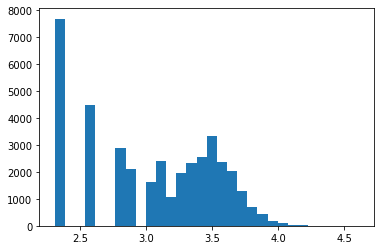

In [15]:
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
promoter = BedTool(os.path.join(ref, 'regions', 'promoter.bed'))

X = []

for t in promoter:
    X.append(abs(int(t[2]) - int(t[1])))
X = np.array(X)
    
plt.hist(np.log10(X+1), bins=30)

In [111]:
genes = BedTool(os.path.join(ref, 'genes', 'genes.gtf'))

gb = []
for x in genes:
    if x.attrs['gene_type'] == 'protein_coding':
        gb.append(x[2])
print(np.unique(gb))

gb = []
for x in genes:
    if np.logical_and(x[2] == 'gene', x.attrs['gene_type'] == 'protein_coding'):
        gb.append(x)
        
gb = BedTool(gb)
print(gb.count())
flank = gb.flank(genome='hg38', l=2000, r=0, s=True)
flank.head()

['CDS' 'Selenocysteine' 'UTR' 'exon' 'gene' 'start_codon' 'stop_codon'
 'transcript']
19901
chr1	HAVANA	gene	63419	65418	.	+	.	gene_id "ENSG00000186092.6";gene_type "protein_coding";gene_name "OR4F5";level 2;havana_gene "OTTHUMG00000001094.4";
 chr1	HAVANA	gene	451698	453697	.	-	.	gene_id "ENSG00000284733.1";gene_type "protein_coding";gene_name "OR4F29";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002860.3";
 chr1	HAVANA	gene	686674	688673	.	-	.	gene_id "ENSG00000284662.1";gene_type "protein_coding";gene_name "OR4F16";level 2;tag "overlapping_locus";havana_gene "OTTHUMG00000002581.3";
 chr1	HAVANA	gene	921928	923927	.	+	.	gene_id "ENSG00000187634.11";gene_type "protein_coding";gene_name "SAMD11";level 2;havana_gene "OTTHUMG00000040719.10";
 chr1	HAVANA	gene	959310	961309	.	-	.	gene_id "ENSG00000188976.10";gene_type "protein_coding";gene_name "NOC2L";level 2;havana_gene "OTTHUMG00000040720.1";
 chr1	HAVANA	gene	958587	960586	.	+	.	gene_id "ENSG00000187961.13";gene_type "prot

In [113]:
flank.bed6().saveas('/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom_test.bed')
flank.saveas('/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom.bed')


<BedTool(/home/camiel/chromograph/chromograph/references/GRCh38_2kbprom.bed)>

In [ ]:
import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request
import logging
import pickle
import importlib

sys.path.append('/home/camiel/chromograph/')
from chromograph.pipeline import config
from chromograph.preprocessing.utils import *
from chromograph.features.feature_count import *
from chromograph.preprocessing.doublet_finder import doublet_finder

ff = '/data/proj/tumor/Healthy_tissues_scATAC/10XPBMC/cellranger/10XPBMC/' + '/outs/fragments.tsv.gz'

logging.info('## Start generating Gene Acessibility Scores ##')
fragments = BedTool(ff)

## Saving fragments in cells

logging.info('Load Genomic regions from reference')
gb = BedTool(os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')).saveas()

logging.info('Intersecting fragments with Genomic regions')
inter = gb.intersect(fragments, wa=True, wb=True)

logging.info('Count promoter overlapping reads per barcode')
Count_dict = Count_genes(meta['barcode'], inter)

logging.info('Reorder data and generate sparse matrix')
r_dict = {k: [] for k in ['Accession', 'Gene', 'loc', 'BPs']}
for x in gb:
    r_dict['Accession'].append(x.attrs['gene_id'])
    r_dict['Gene'].append(x.attrs['gene_name'])
    r_dict['loc'].append(f'{x[0]}:{x[3]}-{x[4]}')
    r_dict['BPs'].append(int(abs(int(x[3])-int(x[4]))))

g_dict = {k: v for v,k in enumerate(r_dict['Accession'])}

## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:

    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(g_dict[key])
        v.append(float(Count_dict[cell][key]))
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(g_dict.keys()), len(meta['barcode']))).tocsr()
logging.info(f'Shape matrix: {matrix.shape}. Number of elements: {matrix.nnz}')

17:56:38 INFO     ## Start generating Gene Acessibility Scores ##
17:56:38 INFO     Load Genomic regions from reference
17:56:38 INFO     Intersecting fragments with Genomic regions


In [65]:
## Create loomfile
logging.info("Constructing loomfile")
floom = '/proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom'

with loompy.connect(f, 'r') as ds:

    loompy.create(filename=floom, 
                  layers=matrix, 
                  row_attrs=r_dict, 
                  col_attrs=meta,
                  file_attrs=ds.attrs)

    logging.info("Loom gene file saved as {}".format(floom))

13:37:36 INFO     Constructing loomfile
13:37:44 INFO     Loom gene file saved as /proj/DEV_ATAC/PBMC_20200825/All/All_prom.loom


In [90]:
from chromograph.pipeline.utils import transfer_ca
with loompy.connect(f, 'r') as ds:
    with loompy.connect(floom) as dsb:
        dsb.ca.CellID = [f'10XPBMC:{x}' for x in ds.ca.barcode]
        transfer_ca(ds, dsb, 'CellID')

16:37:25 INFO     Datasets already ordered


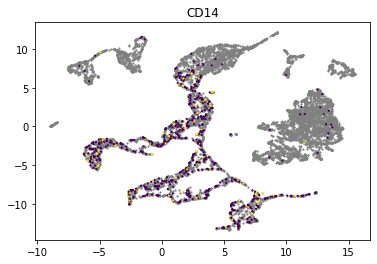

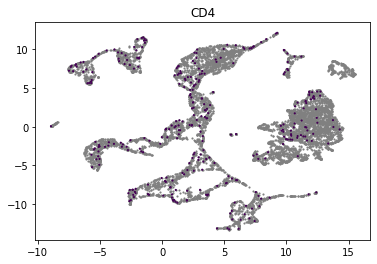

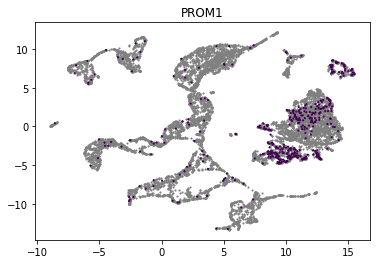

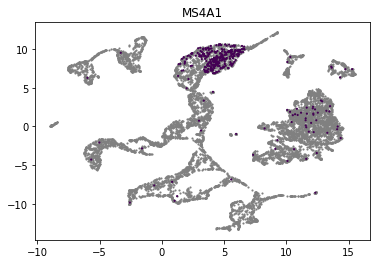

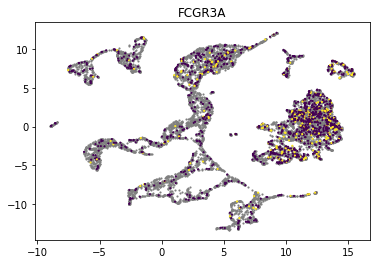

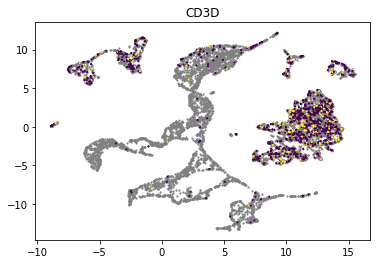

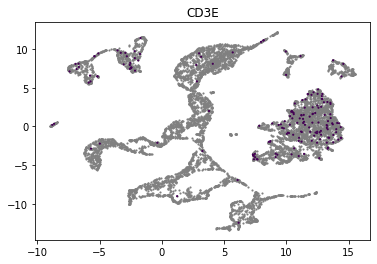

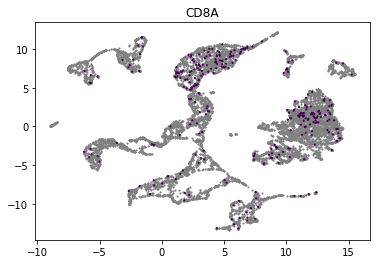

In [110]:
gene = ['CD14', 'CD4', 'PROM1', 'MS4A1', 'FCGR3A', 'CD3D', 'CD3E', 'CD8A']

with loompy.connect(floom) as ds:
    for g in gene:
        X = ds.layers[''][ds.ra.Gene==g,:].flatten()
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c='gray', s=5,  marker='.', vmax=np.quantile(X,0.99))
        plt.scatter(ds.ca.UMAP[X>0,0], ds.ca.UMAP[X>0,1], c=X[X>0], s=5,  marker='.', vmax=np.quantile(X,0.99))
        plt.title(g)

In [2]:
## Import path to the relevant 10X reference dataset

ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
f_atac = '/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom'
f_agg = '/proj/human_development/emelie_20190912/data/Midbrain.agg.loom'

pybedtools.helpers.set_bedtools_path('/data/bin/bedtools2/bin')

pad = 1000

In [152]:
ds = loompy.connect(f_atac, mode='r')
dsa = loompy.connect(f_agg, mode='r', validate=False)

In [5]:
fa = '/home/camiel/misc/10X232_4.bed'
fb = '/home/camiel/misc/10X232_3.bed'

## Setup BedTool 1
logging.info(f"Setup BedTool 1")
frags = BedTool(fa)
# logging.info(f"Merge with file 2")
## Merge with file2
# frags = a.cat(fb)
logging.info(f"Loaded in total {len(frags)} fragments")

10:42:40 INFO     Setup BedTool 1
10:42:40 INFO     Merge with file 2


223299675

In [7]:
(top_enr,) = dsa['enrichment'].map([np.max], axis=0)
q = 1 - (2000 / dsa.shape[0])
lim = np.quantile(top_enr, q)
logging.info(f"Minimum enrichment: {lim} with {sum(top_enr>lim)} genes")
selected = dsa.ra['Accession', 'Gene'][top_enr>lim,:]

10:55:20 INFO     64.28052619313195 with 2000 genes


In [94]:
sel = np.random.choice(np.arange(dsa.shape[0]), size=2000, replace=False)
Rsel = np.zeros(dsa.shape[0], dtype=int)
Rsel[sel] = 1
Random_genes = dsa.ra['Accession', 'Gene'][Rsel,:]
logging.info(f"Selected 2.000 random background genes")

12:18:50 INFO     Selected 2.000 random background genes


In [106]:
def TSS_enrichment(fragments, selected, pad=2000):
    ## Load TSS sites
    tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
    TSS = []
    logging.info(f"Removing TSS not in selection list")
    for x in tss:
        if x[3] in selected:
            TSS.append(x)
    del tss
    TSS = BedTool(TSS)
    logging.info(f"Create padded bedtool")
    TSS_pad = TSS.slop(b=pad, genome = 'hg38')

    ## Filter our fragments not overlapping TSS_pad
    logging.info(f"filter out fragments not overlapping padded area")
    filt = fragments.intersect(TSS_pad)
    logging.info(f"Remaining fragments: {len(filt)}")

    ## Get middle every fragments (mean min/max)
    logging.info(f"Extracting midpoint for all fragments")
    mids = []
    i = 0
    for x in filt:
        st = round((int(x[1]) + int(x[2]))/2)
        end = st + 1
        mids.append([x[0],st, end])
        i += 1
        if i%2000000 == 0:
            logging.info(f"Processed: {i} frags")
    mids = BedTool(mids)

    ## Distance to closest TSS
    logging.info(f"Calculated distancesing")
    dists = mids.sort().closest(TSS.sort(), D='b')

    ## Calculate distances
    logging.info(f"Calculating distances to nearest TSS")
    d = []
    i = 0
    err = []
    for x in dists:
        try:
            d.append(x[10])
        except:
            err.append(x)
        i += 1
        if i%2000000 == 0:
            logging.info(f"Calculated distance for {i} fragments")

    logging.info(f"Sort and return array of TSS enrichment")
    from collections import Counter
    counts = Counter(d)
    pos = []
    for k in counts:
        pos.append((k,counts[k]))
    pos = np.array(pos, dtype=[('dist', int), ('count', float)])
    pos = np.sort(pos, order='dist')

    return pos

logging.info(f"Start processing enriched genes")
pos = TSS_enrichment(frags, selected, pad=pad)
logging.info(f"Start processing background genes")
pos_bg = TSS_enrichment(frags, Random_genes, pad=pad)

13:11:53 INFO     Removing TSS not in selection list
13:12:04 INFO     Create padded bedtool
13:12:04 INFO     filter out fragments not overlapping padded area
13:14:31 INFO     Remaining fragments: 14076449
13:14:31 INFO     Extracting midpoint for all fragments
13:14:38 INFO     1000000
13:14:44 INFO     2000000
13:14:50 INFO     3000000
13:14:57 INFO     4000000
13:15:03 INFO     5000000
13:15:08 INFO     6000000
13:15:15 INFO     7000000
13:15:20 INFO     8000000
13:15:26 INFO     9000000
13:15:32 INFO     10000000
13:15:38 INFO     11000000
13:15:44 INFO     12000000
13:15:49 INFO     13000000
13:15:56 INFO     14000000
13:16:59 INFO     Calculated distancesing
13:17:56 INFO     Calculating distances to nearest TSS
13:18:05 INFO     1000000
13:18:14 INFO     2000000
13:18:22 INFO     3000000
13:18:31 INFO     4000000
13:18:40 INFO     5000000
13:18:48 INFO     6000000
13:18:57 INFO     7000000
13:19:06 INFO     8000000
13:19:14 INFO     9000000
13:19:23 INFO     10000000
13:19:32 

In [118]:
from numpy.lib.recfunctions import append_fields
pos = append_fields(pos, 'fraq', np.zeros(pos.shape[0]))
pos_bg = append_fields(pos_bg, 'fraq', np.zeros(pos_bg.shape[0]))

pos['fraq'] = pos['count']/max(pos['count'])
pos_bg['fraq'] = pos_bg['count']/max(pos_bg['count'])

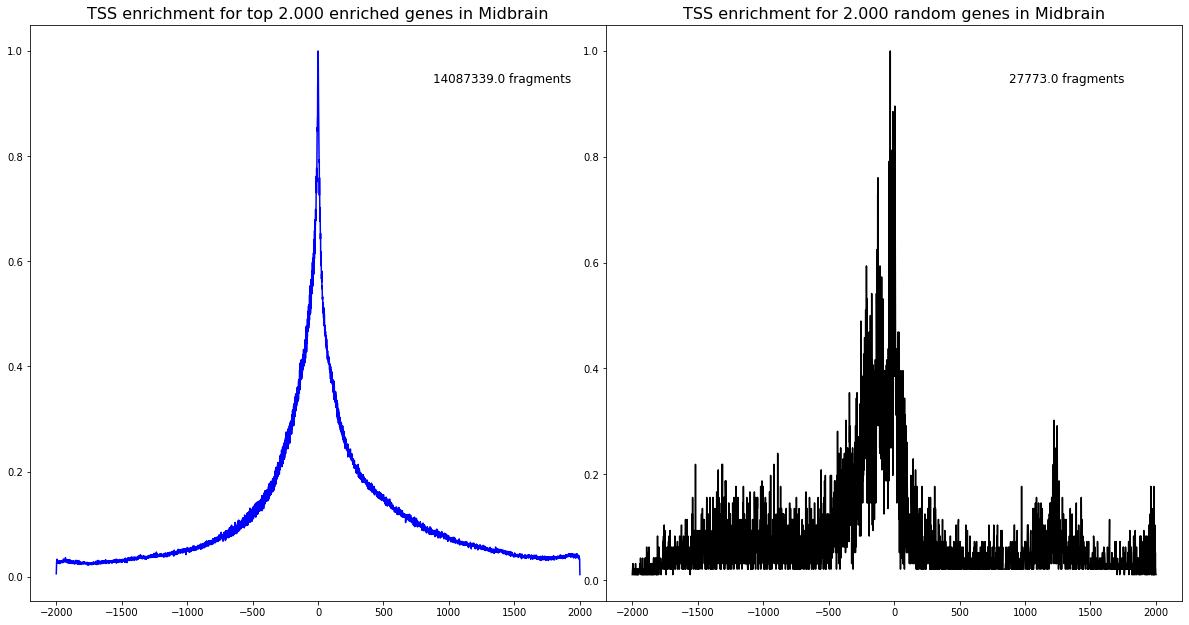

In [149]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_axes([0, 0, 0.5, 1])

ax.plot(pos['dist'], pos['fraq'], c = 'blue')
ax.set_title(f"TSS enrichment for top 2.000 enriched genes in Midbrain", {'fontsize': 16})
ax.text(0.7, 0.9, f"{sum(pos['count'])} fragments", {'fontsize': 12}, transform=ax.transAxes)

ax2 = fig.add_axes([0.5, 0, 0.5, 1])
ax2.plot(pos_bg['dist'], pos_bg['fraq'], c = 'black')
ax2.set_title(f"TSS enrichment for 2.000 random genes in Midbrain", {'fontsize': 16})
ax2.text(0.7, 0.9, f"{sum(pos_bg['count'])} fragments", {'fontsize': 12}, transform=ax2.transAxes)
fig.savefig('/home/camiel/misc/TSS_midbrain_enrichment.png', format="png", dpi=144, bbox_inches='tight')